## BTC Model deployment (30 day lookback)

This notebook will import new data to feed into the trained LSTM model and produce csvs of close price and predictions.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
import datetime as dt
from copy import deepcopy as dc
from tensorflow.keras.models import Sequential
from keras.models import load_model

from api_keys import coinapi_key

2023-09-18 17:31:15.053331: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Pull BTC data from coinapi

url = 'https://rest.coinapi.io/v1/ohlcv/BITSTAMP_SPOT_BTC_USD/history?period_id=1DAY&&time_start=2023-01-02T00:00:00&limit=10000'
headers = {'X-CoinAPI-Key' : coinapi_key}
response = requests.get(url, headers=headers)
 
if response.status_code == 200:
    json_data = response.json()
    print(json_data)
else:
    print(f"Error: {response.status_code}")

[{'time_period_start': '2023-01-02T00:00:00.0000000Z', 'time_period_end': '2023-01-03T00:00:00.0000000Z', 'time_open': '2023-01-02T00:00:23.5020000Z', 'time_close': '2023-01-02T23:59:47.2190000Z', 'price_open': 16615, 'price_high': 16782, 'price_low': 16552, 'price_close': 16673, 'volume_traded': 1046.6584368, 'trades_count': 9780}, {'time_period_start': '2023-01-03T00:00:00.0000000Z', 'time_period_end': '2023-01-04T00:00:00.0000000Z', 'time_open': '2023-01-03T00:00:27.4330000Z', 'time_close': '2023-01-03T23:59:51.6650000Z', 'price_open': 16668, 'price_high': 16766, 'price_low': 16605, 'price_close': 16670, 'volume_traded': 1388.07196613, 'trades_count': 11861}, {'time_period_start': '2023-01-04T00:00:00.0000000Z', 'time_period_end': '2023-01-05T00:00:00.0000000Z', 'time_open': '2023-01-04T00:00:39.2340000Z', 'time_close': '2023-01-04T23:59:41.4680000Z', 'price_open': 16673, 'price_high': 16984, 'price_low': 16652, 'price_close': 16849, 'volume_traded': 2038.03012252, 'trades_count': 1

In [3]:
#Convert json to pandas df
df = pd.DataFrame(json_data)

df.head()

,time_period_start,time_period_end,time_open,time_close,price_open,price_high,price_low,price_close,volume_traded,trades_count
0,2023-01-02T00:00:00.0000000Z,2023-01-03T00:00:00.0000000Z,2023-01-02T00:00:23.5020000Z,2023-01-02T23:59:47.2190000Z,16615,16782,16552,16673,1046.658437,9780
1,2023-01-03T00:00:00.0000000Z,2023-01-04T00:00:00.0000000Z,2023-01-03T00:00:27.4330000Z,2023-01-03T23:59:51.6650000Z,16668,16766,16605,16670,1388.071966,11861
2,2023-01-04T00:00:00.0000000Z,2023-01-05T00:00:00.0000000Z,2023-01-04T00:00:39.2340000Z,2023-01-04T23:59:41.4680000Z,16673,16984,16652,16849,2038.030123,15672
3,2023-01-05T00:00:00.0000000Z,2023-01-06T00:00:00.0000000Z,2023-01-05T00:00:05.6030000Z,2023-01-05T23:59:29.2900000Z,16847,16871,16755,16826,1129.003529,10216
4,2023-01-06T00:00:00.0000000Z,2023-01-07T00:00:00.0000000Z,2023-01-06T00:00:22.2310000Z,2023-01-06T23:59:32.5910000Z,16826,17024,16669,16950,1728.756840,12381


In [4]:
#reduce df to x and y columns
data = df[["time_period_start", "price_close"]]

#rename columns
data = data.rename(columns={"time_period_start":"Date","price_close":"Close"})

#convert date to dt, refomat to yyyymmdd
data['Date'] = pd.to_datetime(data['Date']).dt.date

#set date as index
data.set_index('Date', inplace=True)

data

,Close
Date,
2023-01-02,16673
2023-01-03,16670
2023-01-04,16849
2023-01-05,16826
2023-01-06,16950
...,...
2023-09-14,26529
2023-09-15,26607
2023-09-16,26571


In [5]:
close = data['Close']

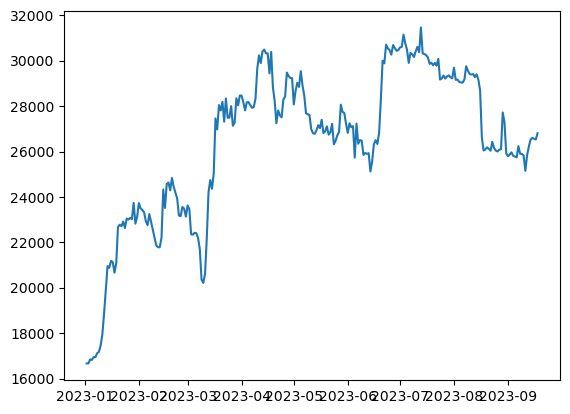

In [6]:
#plot historical eth price
plt.plot(close)

In [7]:
# build 29 day lookback for lstm prediction (we aren't splitting off a y)
def prepare_dataframe_for_lstm(data, n_steps):
    data = dc(data)
    
    for i in range(1, n_steps+1):
        data[f'Close(t-{i})'] = data['Close'].shift(i)
        
    data.dropna(inplace=True)
    
    return data

lookback = 29
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7),Close(t-8),Close(t-9),...,Close(t-20),Close(t-21),Close(t-22),Close(t-23),Close(t-24),Close(t-25),Close(t-26),Close(t-27),Close(t-28),Close(t-29)
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-31,23127,22831.0,23746.0,23033.0,23083.0,23010.0,23054.0,22637.0,22922.0,22717.0,...,17930.0,17446.0,17179.0,17119.0,16945.0,16950.0,16826.0,16849.0,16670.0,16673.0
2023-02-01,23735,23127.0,22831.0,23746.0,23033.0,23083.0,23010.0,23054.0,22637.0,22922.0,...,18853.0,17930.0,17446.0,17179.0,17119.0,16945.0,16950.0,16826.0,16849.0,16670.0
2023-02-02,23498,23735.0,23127.0,22831.0,23746.0,23033.0,23083.0,23010.0,23054.0,22637.0,...,19931.0,18853.0,17930.0,17446.0,17179.0,17119.0,16945.0,16950.0,16826.0,16849.0
2023-02-03,23434,23498.0,23735.0,23127.0,22831.0,23746.0,23033.0,23083.0,23010.0,23054.0,...,20960.0,19931.0,18853.0,17930.0,17446.0,17179.0,17119.0,16945.0,16950.0,16826.0
2023-02-04,23330,23434.0,23498.0,23735.0,23127.0,22831.0,23746.0,23033.0,23083.0,23010.0,...,20885.0,20960.0,19931.0,18853.0,17930.0,17446.0,17179.0,17119.0,16945.0,16950.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-14,26529,26226.0,25844.0,25155.0,25836.0,25899.0,25908.0,26245.0,25748.0,25783.0,...,26048.0,26168.0,26431.0,26042.0,26125.0,26192.0,26097.0,26051.0,26642.0,28701.0
2023-09-15,26607,26529.0,26226.0,25844.0,25155.0,25836.0,25899.0,25908.0,26245.0,25748.0,...,26008.0,26048.0,26168.0,26431.0,26042.0,26125.0,26192.0,26097.0,26051.0,26642.0
2023-09-16,26571,26607.0,26529.0,26226.0,25844.0,25155.0,25836.0,25899.0,25908.0,26245.0,...,26090.0,26008.0,26048.0,26168.0,26431.0,26042.0,26125.0,26192.0,26097.0,26051.0


In [8]:
#create array of dates for plotting from new index. 
dates = shifted_df.index

dates.shape

(227,)

In [9]:
#convert from df to numpy array
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

#Log scale data
log_transformed_data = np.log(shifted_df_as_np)

log_transformed_data.shape

(227, 30)

In [10]:
#Flip lookback axis so that most recent day is last -7, -6, -5, -4, -3, -2, -1, predict next
X = dc(np.flip(log_transformed_data, axis=1))

In [35]:
#load trained model
model = load_model("H5_Files/btc_30_day_1.h5")

In [36]:
#build predictions for first model
predictions = []
predicted_dates = []
prediction_range = 7

#create list of numbers to add to date based on date range
date_range = list(range(1, prediction_range +1))


# Use last (most recent) window to predict next day
current_batch = X[-1]
current_reshape = current_batch.reshape((1, 30, 1))
initial_date = dates[-1]

for i in range(prediction_range):  # Generate predictions for 7 days
    # Predict the next data point
    current_pred = model.predict(current_reshape)[0,0]
    
    # Append the prediction to the list of predictions
    predictions.append(current_pred)
        
    # Update initial input for the next step
    updated_batch = np.insert(current_batch, -1, current_pred)
    
    #resize batch 
    current_batch = updated_batch[1:]
    
    #reshape batch
    current_reshape = current_batch.reshape((1, 30, 1))

    
#Add future dates for predictions  
for day in date_range:
    new_date = initial_date + dt.timedelta(days=day)
    predicted_dates.append(new_date
                          )
# 'predictions' contains 7-day forecast
print(predictions)

for date in predicted_dates:
    print(date)

1/1 [==============================] - 0s 27ms/step
[10.288114, 10.292182, 10.29301, 10.293806, 10.294033, 10.294115, 10.294203]
2023-09-19
2023-09-20
2023-09-21
2023-09-22
2023-09-23
2023-09-24
2023-09-25


In [37]:
#load trained model 2
model2 = load_model("H5_Files/btc_30_day_2.h5")
#load trained model 3
model3 = load_model("H5_Files/btc_30_day_3.h5")

In [38]:
#build predictions for second 2 models

# Initialize an array to store predictions
predictions2 = []
prediction_range2 = 7

current_batch = X[-1]
current_reshape = current_batch.reshape((1, 30, 1))
initial_date = dates[-1]

for i in range(prediction_range):  # Generate predictions for 7 days
    # Predict the next data point
    current_pred = model2.predict(current_reshape)[0,0]
    
    # Append the prediction to the list of predictions
    predictions2.append(current_pred)
        
    # Update initial input for the next step
    updated_batch = np.insert(current_batch, -1, current_pred)
    
    #resize batch 
    current_batch = updated_batch[1:]
    
    #reshape batch
    current_reshape = current_batch.reshape((1, 30, 1))

    #build predictions for first model


    # Initialize an array to store predictions
predictions3 = []
prediction_range3 = 7

current_batch = X[-1]
current_reshape = current_batch.reshape((1, 30, 1))
initial_date = dates[-1]

for i in range(prediction_range):  # Generate predictions for 7 days
    # Predict the next data point
    current_pred = model3.predict(current_reshape)[0,0]
    
    # Append the prediction to the list of predictions
    predictions3.append(current_pred)
        
    # Update initial input for the next step
    updated_batch = np.insert(current_batch, -1, current_pred)
    
    #resize batch 
    current_batch = updated_batch[1:]
    
    #reshape batch
    current_reshape = current_batch.reshape((1, 30, 1))

print(predictions2)
print(predictions3)


1/1 [==============================] - 0s 24ms/step
[10.210225, 10.213615, 10.214501, 10.214826, 10.214979, 10.215046, 10.215066]
[10.187741, 10.187308, 10.186943, 10.186678, 10.186515, 10.186372, 10.186285]


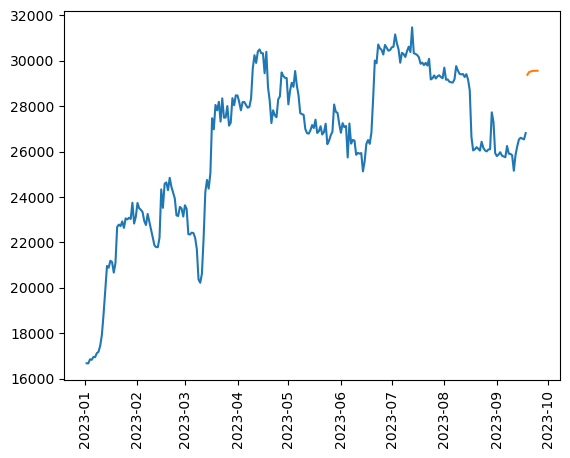

In [39]:
plt.plot(close)
plt.plot(predicted_dates, np.exp(predictions))
plt.xticks(rotation=90)

plt.show()

In [40]:
# build output into a df for graphing in js

df = pd.DataFrame({"Date": dates, "observed":close[lookback:]})
df.set_index('Date', inplace=True)

df2 = pd.DataFrame({"Date": predicted_dates, "future_prediction":np.exp(predictions),\
                    "future_prediction2": np.exp(predictions2), "future_prediction3": np.exp(predictions3)})
df2.set_index('Date', inplace=True)                   
                    
past_future_df = pd.merge(df,df2, how='outer', left_index=True, right_index=True)


past_future_df.head()


,observed,future_prediction,future_prediction2,future_prediction3
Date,,,,
2023-01-31,23127.0,NaN,NaN,NaN
2023-02-01,23735.0,NaN,NaN,NaN
2023-02-02,23498.0,NaN,NaN,NaN
2023-02-03,23434.0,NaN,NaN,NaN
2023-02-04,23330.0,NaN,NaN,NaN


In [41]:
past_future_df.tail(12)



,observed,future_prediction,future_prediction2,future_prediction3
Date,,,,
2023-09-14,26529.0,NaN,NaN,NaN
2023-09-15,26607.0,NaN,NaN,NaN
2023-09-16,26571.0,NaN,NaN,NaN
2023-09-17,26535.0,NaN,NaN,NaN
2023-09-18,26811.0,NaN,NaN,NaN
2023-09-19,NaN,29381.296875,27179.685547,26575.400391
2023-09-20,NaN,29501.076172,27271.988281,26563.894531
2023-09-21,NaN,29525.505859,27296.162109,26554.195312
2023-09-22,NaN,29549.027344,27305.013672,26547.156250


In [42]:
pred_columns = past_future_df[['future_prediction','future_prediction2','future_prediction3' ]]

pred_means = pred_columns.mean(axis=1)

past_future_df['mean'] = pred_means

past_future_df_30 = past_future_df.copy()

past_future_df_30

,observed,future_prediction,future_prediction2,future_prediction3,mean
Date,,,,,
2023-01-31,23127.0,NaN,NaN,NaN,NaN
2023-02-01,23735.0,NaN,NaN,NaN,NaN
2023-02-02,23498.0,NaN,NaN,NaN,NaN
2023-02-03,23434.0,NaN,NaN,NaN,NaN
2023-02-04,23330.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2023-09-21,NaN,29525.505859,27296.162109,26554.195312,27791.953125
2023-09-22,NaN,29549.027344,27305.013672,26547.156250,27800.398438
2023-09-23,NaN,29555.736328,27309.205078,26542.830078,27802.591797


In [43]:
past_future_df_30.to_csv('output/btc_model_30.csv') 